In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
import pandas as pd
from itertools import combinations

from PA_functions import plot_results, preprocess_our, ouropt_1, ouropt_2, convert_operations, preprocess_our
from scipy.optimize import LinearConstraint
from scipy.optimize import fsolve
from scipy import stats as st

### Select files and define optimization settigs

In [2]:
folder = './../Data_Base/Maria/'                                 
file = 'Maria_placido'

use_all_peaks = 1                           # Use all peaks? (1 Yes, 0 No)
peaks_to_analyze = 12                       # How many peaks use?

delta = 0.05                        # Expected maximum deviation from 1/1 of the mass of each EM injected in the device
max_cv = 5                          # Max allowed CV for repetitions
cv = 0.5                            # Initial guess of the CV

#### Count end members and ratios

In [3]:
dataset = pd.read_csv(folder+'/'+file+".csv", sep = ',').set_index('Mix')
dataset['Replicate'] = dataset.groupby(level=0).cumcount() + 1
dataset.reset_index(inplace=True)
dataset.set_index(['Mix', 'Replicate'], inplace=True)

unique_fluids = dataset.index.get_level_values(0).unique()
nEM = unique_fluids.str.startswith('EM').sum()
nMix = unique_fluids.str.startswith('M').sum()

print('You have '+str(nEM)+' End Members and '+str(nMix)+' Mixtures')

You have 6 End Members and 16 Mixtures


#### Preprocessing

In [4]:
todo = dataset.iloc[:,:].copy()
replicates_deleted = []

max_cv_replicates_fluids = ((todo.groupby(level=0).std(ddof = 1))*100/todo.groupby(level=0).mean()).max(axis = 1)

while len(max_cv_replicates_fluids[max_cv_replicates_fluids>max_cv]) != 0:
    max_cv_replicates_peaks = ((todo.groupby(level=0).std(ddof = 1))*100/todo.groupby(level=0).mean()).max(axis = 0)
    bad_columns = np.array(max_cv_replicates_peaks[max_cv_replicates_peaks>max_cv].index, dtype = int)
    max_cv_replicates_fluids = ((todo.groupby(level=0).std(ddof = 1))*100/todo.groupby(level=0).mean()).max(axis = 1)
    mixture_to_check = max_cv_replicates_fluids.idxmax()

    repetition_to_drop = abs(todo.loc[mixture_to_check]-todo.loc[mixture_to_check].median())[bad_columns.astype(str)].idxmax(axis = 0).value_counts().idxmax()
    todo.drop((mixture_to_check, repetition_to_drop), inplace = True)
    replicates_deleted.append((mixture_to_check, repetition_to_drop))
    max_cv_replicates_fluids = ((todo.groupby(level=0).std(ddof = 1))*100/todo.groupby(level=0).mean()).max(axis = 1)

if len(replicates_deleted) == 0:
    print('No replicates were deleted, seems that this is a good dataset!')
else: 
    print('The following '+str(len(replicates_deleted))+' replicates were deleted:')
    print(replicates_deleted)

aaa = todo.groupby(level=0).count().iloc[:,0] == 1
if len(aaa[aaa]) != 0:
    print('\nCareful! Only one replicate per fluid in the following fluids:')
    print(aaa[aaa].index.values)

    print('\nThis indicates that the dataset has problems of repeatability')

The following 54 replicates were deleted:
[('M10', 1), ('M10', 5), ('M6', 1), ('M6', 2), ('EM5', 10), ('EM5', 9), ('EM5', 7), ('EM5', 1), ('EM5', 8), ('EM5', 2), ('M4', 5), ('M4', 4), ('M4', 1), ('M4', 2), ('M7', 2), ('M7', 3), ('M7', 4), ('M9', 1), ('M9', 5), ('M9', 3), ('EM4', 7), ('EM4', 4), ('EM4', 8), ('EM4', 3), ('EM4', 5), ('EM4', 6), ('M11', 1), ('EM6', 9), ('M1', 1), ('M1', 3), ('M1', 2), ('M1', 4), ('M12', 5), ('M14', 1), ('M14', 5), ('M14', 4), ('M14', 2), ('M7', 1), ('EM2', 4), ('EM4', 1), ('M3', 5), ('M3', 4), ('M13', 1), ('M9', 2), ('EM6', 2), ('EM6', 1), ('EM3', 4), ('M5', 3), ('M5', 2), ('M5', 1), ('M5', 4), ('EM5', 4), ('EM5', 3), ('EM5', 5)]

Careful! Only one replicate per fluid in the following fluids:
['EM4' 'EM5' 'M1' 'M14' 'M4' 'M5' 'M7' 'M9']

This indicates that the dataset has problems of repeatability


In [5]:
dataset = todo.copy().reset_index()
dataset = dataset.drop(columns = 'Replicate').set_index('Mix')

if use_all_peaks == 0:
    peaks = dataset.iloc[:,0:peaks_to_analyze+1]
else:
    peaks = dataset.iloc[:,:]

#### Where are the operations? Convert the operations from the text file to an array easier to manipulate

In [6]:
operations = 'operations_all.txt'
if use_all_peaks == 0: 
    operations = 'operations'+str(peaks_to_analyze)+'.txt'
operations_path=folder+'/'+operations
def_operations, tipo = convert_operations(operations_path)

#### Define end members and mixtures list with names, then create space to store results

In [7]:
end_members = ['EM'+str(x+1) for x in range(nEM)]
mixtures = ['M' + str(x+1) for x in range(nMix)]

# Create an array to storage the results
X_todos = np.zeros((nEM, nMix))

#### Optimization Algorithm (this is the core of the code)

In [8]:
for i in range(nMix):
    # Define the unknown mixtures, create end members array, create unknown mixtures array
    unknown_mixtures = mixtures[i]
    print('Working on mixture '+unknown_mixtures)

    # Average chromatograms
    em_peaks_mean = dataset.loc[end_members].groupby(level = 0).mean()
    um_peaks_mean = dataset.loc[unknown_mixtures].groupby(level = 0).mean()
    if dataset.loc[unknown_mixtures].shape[0] == dataset.loc[unknown_mixtures].size:   # If there is only one repetition
        um_peaks_mean = dataset.loc[unknown_mixtures]

    # Define vector of unknowns and initialize its values
    #give an initial value to CV, and define bounds for the optimization
    unknowns = np.ones(2*nEM-1)  # [X1, X2, X3, ..., MR1, MR2] 
    lb = np.ones((nEM)+nEM-1)*(1-delta)
    ub = np.ones((nEM)+nEM-1)*(1+delta)
    lc = np.zeros((nEM)+nEM-1)
    unknowns[:-(nEM-1)] = 100/nEM
    lb[:-(nEM-1)] = 0
    ub[:-(nEM-1)] = 100
    lc[:-(nEM-1)] = 1
    
    bounds_x = Bounds(lb, ub)
    bounds_cv = [(0.038,1)]
    linear_constraint = LinearConstraint(lc.tolist(), [100], [100])

    C = 10
    while C > 0.01:
    # Minimize objective function to obtain values of unknowns
        res = minimize(ouropt_1, unknowns, method = 'SLSQP', constraints=linear_constraint, bounds = bounds_x, args = (def_operations, em_peaks_mean.values, um_peaks_mean.values, tipo, cv, nEM))
        unknowns = res.x
        C1 = cv

        # Update the value of the cv considering the values of the unknowns obtained in the previous step
        res = minimize(ouropt_2, cv, method = 'SLSQP', bounds = bounds_cv, args = (unknowns, def_operations, em_peaks_mean.values, um_peaks_mean.values, tipo, nEM))
        cv = res.x 
        C = abs(C1-cv)

    for j in range(nEM):
        X_todos[j,i] = unknowns[j]

Working on mixture M1


C:\Users\Leonardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Working on mixture M2
Working on mixture M3
Working on mixture M4
Working on mixture M5
Working on mixture M6
Working on mixture M7
Working on mixture M8
Working on mixture M9
Working on mixture M10
Working on mixture M11
Working on mixture M12
Working on mixture M13
Working on mixture M14
Working on mixture M15
Working on mixture M16


#### Visualize Results

Text(0.5, 0, 'Mixtures')

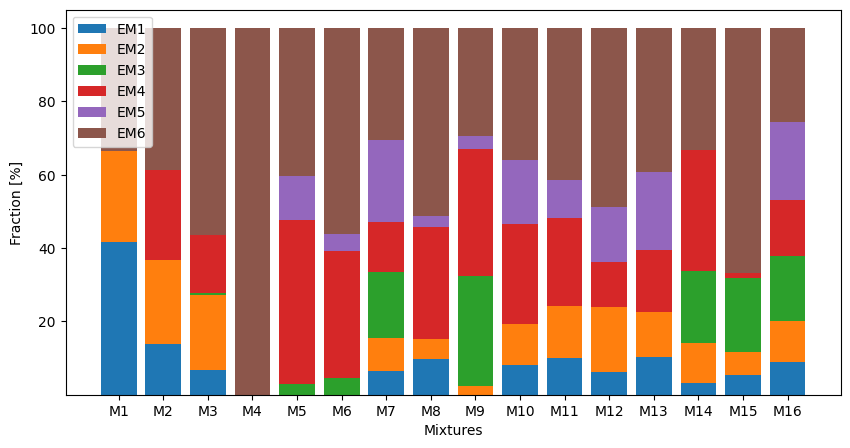

In [9]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

bottom = np.zeros(nMix)
for i in range(nEM):
    ax.bar(np.arange(1,nMix+1), X_todos[i,:], label = end_members[i], bottom = bottom)
    bottom += X_todos[i,:]
ax.set_xticks(np.arange(1,nMix+1))
ax.set_xticklabels(mixtures)
ax.legend()
ax.set_ylabel('Fraction [%]')
ax.set_xlabel('Mixtures')


#### Results in numbers (they may not sum 100 due to decimal truncation, if you want the decimal figures you can check X_todos variable)

In [10]:
for i in range(nMix):
    print(mixtures[i], X_todos[:,i].astype(int))

M1 [41 24  0  0  0 33]
M2 [13 22  0 24  0 38]
M3 [ 6 20  0 15  0 56]
M4 [  0   0   0   0   0 100]
M5 [ 0  0  3 44 11 40]
M6 [ 0  0  4 34  4 56]
M7 [ 6  9 18 13 22 30]
M8 [ 9  5  0 30  2 51]
M9 [ 0  2 29 34  3 29]
M10 [ 8 11  0 27 17 35]
M11 [10 13  0 24 10 41]
M12 [ 6 17  0 12 14 48]
M13 [10 12  0 16 21 39]
M14 [ 3 10 19 33  0 33]
M15 [ 5  6 20  1  0 66]
M16 [ 8 11 17 15 21 25]
